In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
from io import BytesIO
from glob import glob


import numpy as np

import urllib
import erikutils

from astropy import units as u
from astropy import modeling
from astropy.table import Table
from astropy.io import fits
from astropy import constants as cnst
from astropy.coordinates import Angle, SkyCoord
from astropy import visualization, convolution

from IPython import display
from PIL import Image, ImageDraw

In [3]:
%matplotlib inline
from matplotlib import rcParams, style
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

rcParams['image.cmap'] = 'viridis'
rcParams['image.origin'] = 'lower'
rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
rcParams['figure.figsize'] = (14, 8)
rcParams['axes.titlesize'] =  rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] =  rcParams['ytick.labelsize'] = 14

In [4]:
# valid for erik's computer
os.environ['DEEP_DIR'] = '/Volumes/ErikDroboData/data/DEIMOS/'

In [5]:
dirs = {nm: os.path.join(os.environ['DEEP_DIR'], nm) for nm in ('Gil1', 'DN1', 'MD2')}
spec1d_fns = {nm: glob(os.path.join(dirs[nm], 'spec1d*')) for nm in dirs}
slit_fns = {nm: glob(os.path.join(dirs[nm], 'slit*')) for nm in dirs}

In [6]:
def show_all_slits(target, scalekwargs=dict(scale='asinh', percent=99)):
    plt.figure(figsize=(16, 24))

    for i, fn in enumerate(slit_fns[target]):
        plt.subplot(12, 2, i+1)
        erikutils.deimosutils.show_deimos_slit(fn, scalekwargs=scalekwargs)
        plt.title(os.path.split(fn)[-1])
    plt.tight_layout()

In [7]:
def find_match(substr, target):
    idx = [i for i, fn in enumerate(fns[target]) if substr in fn]
    assert len(idx)==1
    return spec1d_fns[target][idx[0]]

# Gil1 

In [8]:
obj = 'Gil1'
zhost = .00658

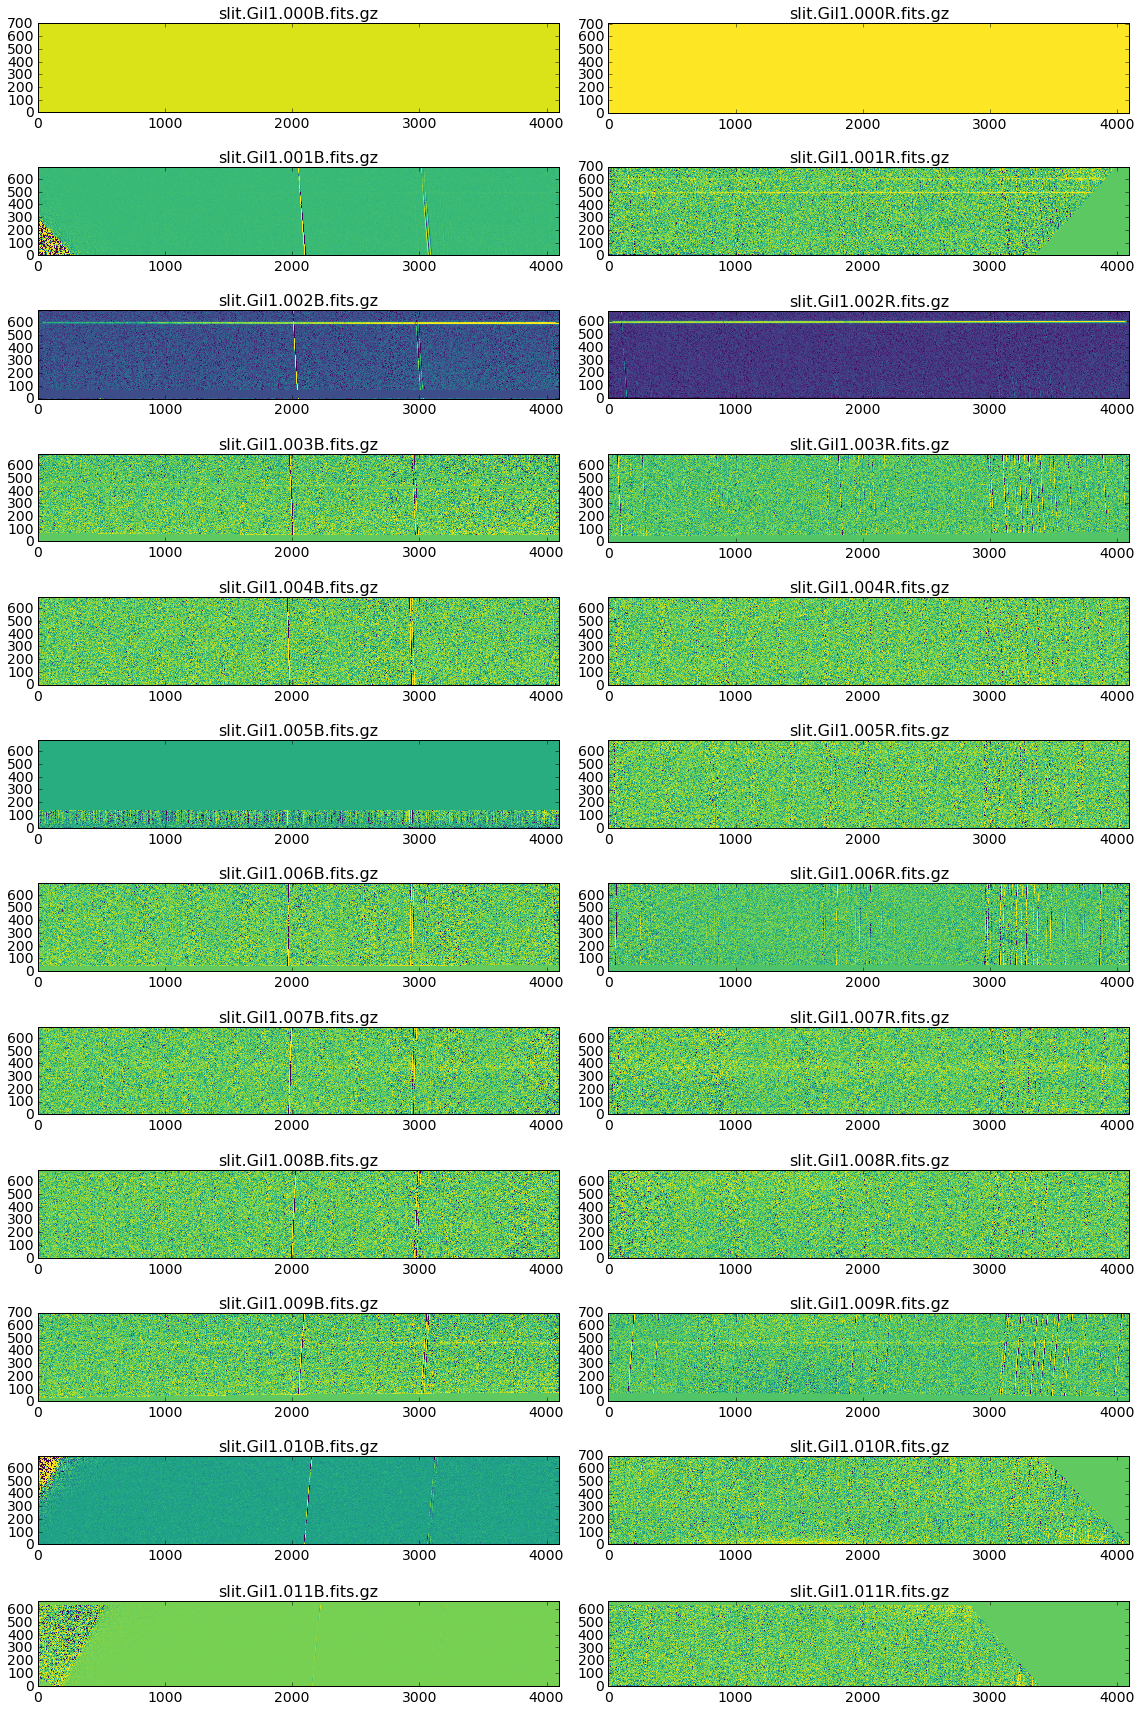

In [9]:
show_all_slits(obj)

### Might it be the thing in slit 009? Has em lines...

/Users/erik/src/erikutils/erikutils/deimosutils.py:223: RuntimeWarning: divide by zero encountered in power
  plt.plot(xb, bivar**-0.5, color='k', ls=':')
/Users/erik/src/erikutils/erikutils/deimosutils.py:224: RuntimeWarning: divide by zero encountered in power
  plt.plot(xr, rivar**-0.5, color='k', ls=':')


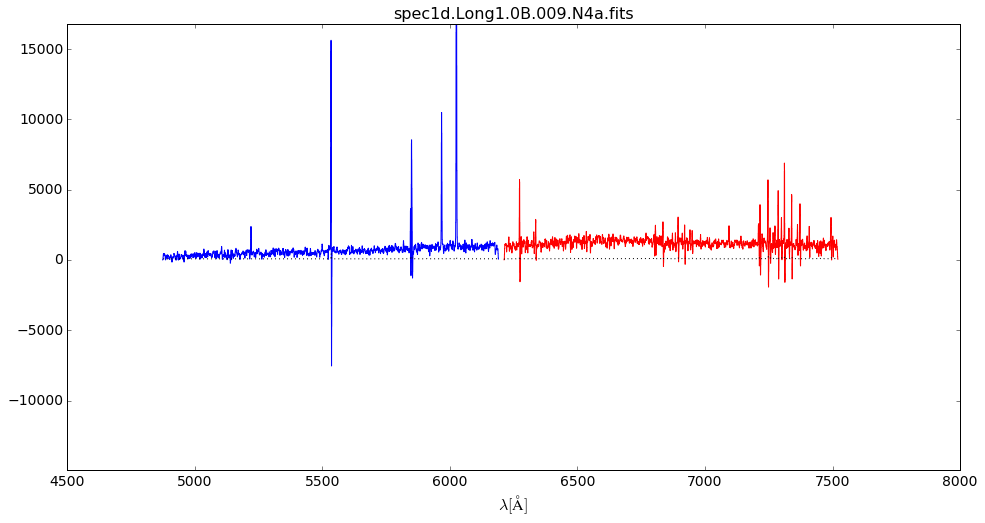

In [10]:
goodfns = []
for fn in spec1d_fns[obj]:
    if '009' not in fn or 'serendip' in fn:
        continue
        
    plt.figure(figsize=(16,8))
    xb, bspec, xr, rspec = erikutils.deimosutils.plot_deimos_spec1d(fn, smoothing=-2, mady=50)
    goodfns.append(fn)
    plt.title(os.path.split(fn)[-1])

<CompoundModel1(amplitude_0=2501.37314868132, mean_0=5967.104042973948, stddev_0=0.7649910153068238, amplitude_1=7598.091980936616, mean_1=6025.033225774953, stddev_1=0.8235727235121495, amplitude_2=187.45143718802396)>

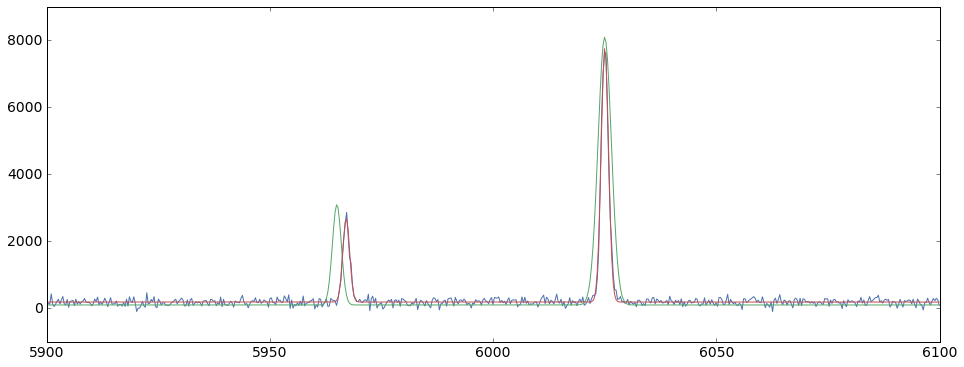

In [11]:
_, xb, bspec, xr, rspec, _, _ = erikutils.deimosutils.get_deimos_spec1d(goodfns[0])

msk = (5900<xb)&(xb<6100)

model0 = (modeling.models.Gaussian1D(amplitude=3000,mean=5965, stddev=1.) + 
          modeling.models.Gaussian1D(amplitude=8000,mean=6025, stddev=1.5) + 
          modeling.models.Const1D(amplitude=100))

model = modeling.fitting.LevMarLSQFitter()(model0, xb[msk], bspec[msk])

plt.figure(figsize=(16, 6))
plt.plot(xb[msk], bspec[msk])
plt.plot(xb[msk], model0(xb[msk]))
plt.plot(xb[msk], model(xb[msk]))
model

In [12]:
np.array([model.mean_0.value/4959, model.mean_1.value/5007])-1

array([ 0.20328777,  0.20332199])

Target is clearly at a redshift of ~.2, so not a satellite

### Show where the slit might be 

The info in the `spec1d` files/bintabs is useless for longslits - the RA and Decs don't make sense.  So lets just guess for now

In [13]:
def get_cutout_url(coo, sz, opts='', scale=0.4*u.arcsec/u.pixel):
    if scale.unit.is_equivalent(u.pixel/u.arcsec):
        scale = 1/scale
    elif not scale.unit.is_equivalent(u.arcsec/u.pixel):
        raise ValueError('wrong units in scale')
        
    if sz.unit.is_equivalent(u.arcsec):
        h = w = int(round((sz/scale).to(u.pixel).value))
    elif sz.unit.is_equivalent_to(u.pixel):
        h = w = int(round(sz.to(u.pixel).value))
    else:
        raise ValueError('wrong unit in sz')
    
    base_url = 'http://skyserver.sdss.org/SkyserverWS/dr12/ImgCutout/getjpeg'
    data = [('ra', coo.ra.deg), ('dec', coo.dec.deg), ('width', w), ('height', h), 
            ('opt', opts), ('scale', scale.to(u.arcsec/u.pixel).value)]
    return base_url + '?' + urllib.parse.urlencode(data)

def draw_box(im, xcen ,ycen, width, height, color='red', rot=0*u.deg, pxscale=None):
    if pxscale is not None:
        width = (width/pxscale).to(u.pixel).value
        height = (height/pxscale).to(u.pixel).value
    
    x1 = -width//2
    x2 = width//2
    y1 = -height//2
    y2 = height//2
    xys = np.array([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
    
    rmat = np.array([[np.cos(rot), np.sin(rot)],[-np.sin(rot),np.cos(rot)]])
    xys = np.dot(rmat, xys.T)
    
    xys[0, :] += xcen
    xys[1, :] += ycen
    
    draw = ImageDraw.Draw(im)
    draw.polygon(list(xys.T.ravel()), outline=color)
    return draw

def pil_to_ipy_im(pilim):
    bio = BytesIO()
    pilim.save(bio, 'png')
    return display.Image(bio.getvalue())

pxscale = 1*u.arcsec/u.pixel

In [14]:
h = fits.getheader(spec1d_fns[obj][0], 1)
sccen = SkyCoord(h['RA'], h['DEC'], unit=(u.hour, u.deg))
url = get_cutout_url(sccen, 16*u.arcmin, scale=pxscale, opts='G')
sccen

<SkyCoord (ICRS): (ra, dec) in deg
    (234.22091667, 16.60136111)>

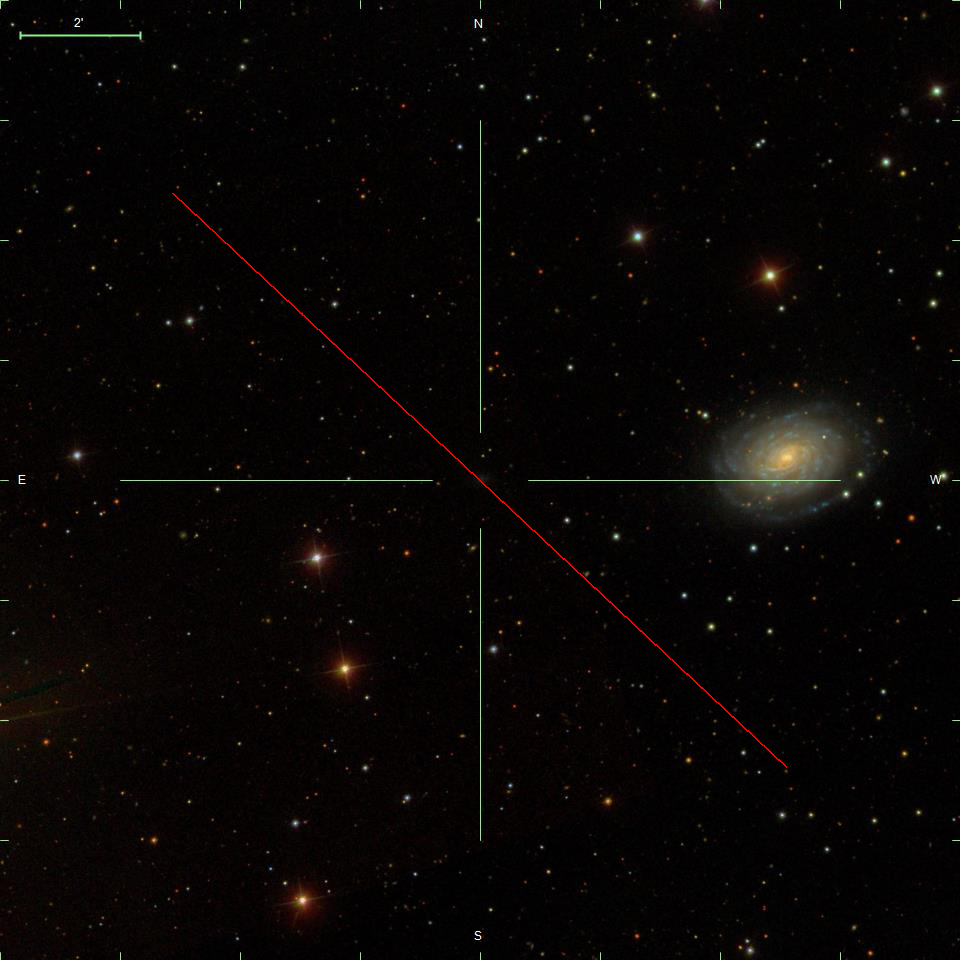

In [15]:
im = Image.open(urllib.request.urlopen(url))

# it's not actuall 90 deg from ROTATVAL to slit angle... but it's not totally wrong?  Maybe?
draw_box(im, im.width//2, im.height//2, 14*u.arcmin, 1*u.arcsec,  
         rot=h['ROTATVAL']*u.deg+90*u.deg, pxscale=pxscale)
pil_to_ipy_im(im)

Aha - there *is* a distant spiral galax-y thing ~2 arcmin away - might be the em line object?  So lets look at the other nearby brightish slit

### 007 

This one also looks more promising in that it is significantly boader spatially than the em line thingie

In [16]:
fns = [fn for fn in spec1d_fns[obj] if '007' in fn]
hs = [fits.getheader(fn, 1) for fn in fns]
{fn:h['SLITX0']+h['OBJPOS'] for fn,h in zip(fns,hs)}

{'/Volumes/ErikDroboData/data/DEIMOS/Gil1/spec1d.Long1.0B.007.N3b.fits': 1032.307,
 '/Volumes/ErikDroboData/data/DEIMOS/Gil1/spec1d.Long1.0B.007.serendip1.fits': 702.3207000000001}

Inspection of the raw data (and allsits files) shows that the one at 1032 is the right one

/Users/erik/src/erikutils/erikutils/deimosutils.py:223: RuntimeWarning: divide by zero encountered in power
  plt.plot(xb, bivar**-0.5, color='k', ls=':')
/Users/erik/src/erikutils/erikutils/deimosutils.py:224: RuntimeWarning: divide by zero encountered in power
  plt.plot(xr, rivar**-0.5, color='k', ls=':')


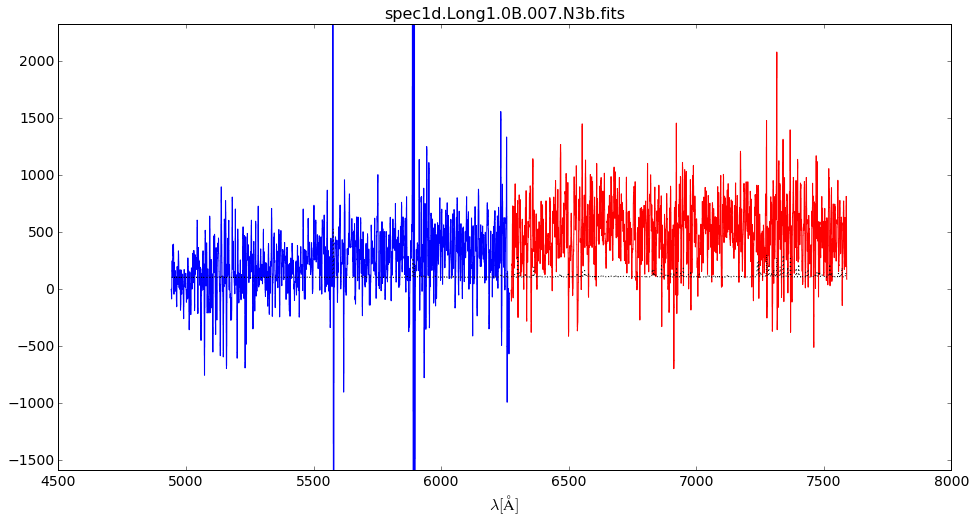

In [17]:
goodfns = []
for fn in spec1d_fns[obj]:
    if '007' not in fn or 'serendip' in fn:
        continue
        
    plt.figure(figsize=(16,8))
    erikutils.deimosutils.plot_deimos_spec1d(fn, smoothing=-2, mady=10)
    goodfns.append(fn)
    plt.title(os.path.split(fn)[-1])

Pretty low flux... no emission, but the image is pretty red, so not too surprising.  Lets look for absorption lines.

In [18]:
lines = [4861, 5175, 5890, 5896, 6563, 8498.03, 8542.09, 8662.14]*u.angstrom
lines = lines*(1+zhost)
lines

<Quantity [ 4892.98538  , 5209.0515   , 5928.7562   , 5934.79568  ,
            6606.18454  , 8553.9470374, 8598.2969522, 8719.1368812] Angstrom>

Hbeta and CaT are out-of-band...

### Halpha

/Users/erik/src/erikutils/erikutils/deimosutils.py:223: RuntimeWarning: divide by zero encountered in power
  plt.plot(xb, bivar**-0.5, color='k', ls=':')
/Users/erik/src/erikutils/erikutils/deimosutils.py:224: RuntimeWarning: divide by zero encountered in power
  plt.plot(xr, rivar**-0.5, color='k', ls=':')


(6550, 6650)

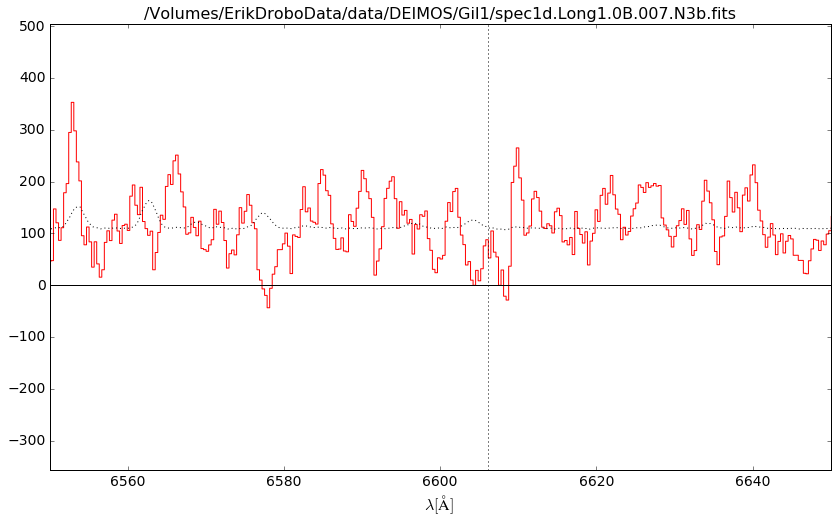

In [19]:
erikutils.deimosutils.plot_deimos_spec1d(goodfns[0], smoothing=5, mady=10)

for line in lines:
    plt.axvline(line.value, c='k', ls=':')
plt.axhline(0, color='k', ls='-')
plt.xlim(6550, 6650)

### NaD

/Users/erik/src/erikutils/erikutils/deimosutils.py:223: RuntimeWarning: divide by zero encountered in power
  plt.plot(xb, bivar**-0.5, color='k', ls=':')
/Users/erik/src/erikutils/erikutils/deimosutils.py:224: RuntimeWarning: divide by zero encountered in power
  plt.plot(xr, rivar**-0.5, color='k', ls=':')


(5900, 6000)

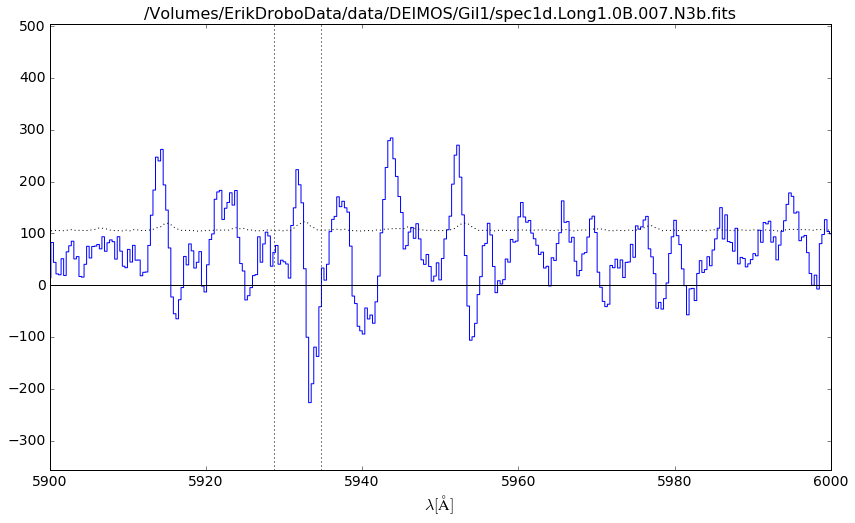

In [20]:
erikutils.deimosutils.plot_deimos_spec1d(goodfns[0], smoothing=5, mady=10)

for line in lines:
    plt.axvline(line.value, c='k', ls=':')
plt.axhline(0, color='k', ls='-')
plt.xlim(5900, 6000)

### MgIb

/Users/erik/src/erikutils/erikutils/deimosutils.py:223: RuntimeWarning: divide by zero encountered in power
  plt.plot(xb, bivar**-0.5, color='k', ls=':')
/Users/erik/src/erikutils/erikutils/deimosutils.py:224: RuntimeWarning: divide by zero encountered in power
  plt.plot(xr, rivar**-0.5, color='k', ls=':')


(5180, 5230)

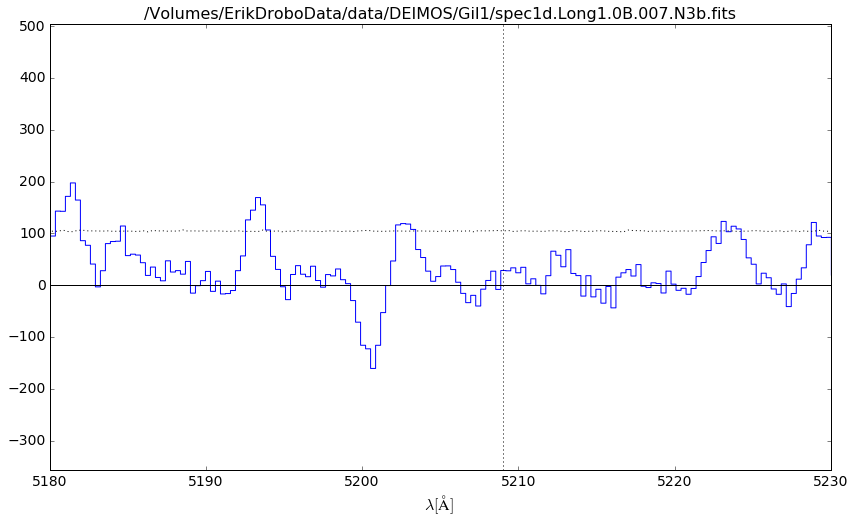

In [21]:
erikutils.deimosutils.plot_deimos_spec1d(goodfns[0], smoothing=5, mady=10)

for line in lines:
    plt.axvline(line.value, c='k', ls=':')
plt.axhline(0, color='k', ls='-')
plt.xlim(5180, 5230)

Grr... Still inconclusive.  Flux too low on blue end, but *maybe* Halpha?

## Try re-reducing manually from the 2d spectrum 

In [22]:
slit_7r = [fn for fn in slit_fns['Gil1'] if '007R' in fn][0]
f = fits.open(slit_7r)
f.verify('silentfix')

In [23]:
d = f[1].data
f[1].data.dtype

dtype((numpy.record, [('FLUX', '>f4', (690, 4096)), ('IVAR', '>f4', (690, 4096)), ('MASK', 'u1', (690, 4096)), ('CRMASK', 'u1', (690, 4096)), ('LAMBDA0', '>f4', (4096,)), ('DLAMBDA', '>f4', (690, 4096)), ('LAMBDAX', '>f8', (6,)), ('TILTX', '>f8', (5,)), ('SLITFN', '>f4', (690,)), ('DLAM', '>f8', (3, 690)), ('INFOMASK', '>i4', (690, 4096))]))

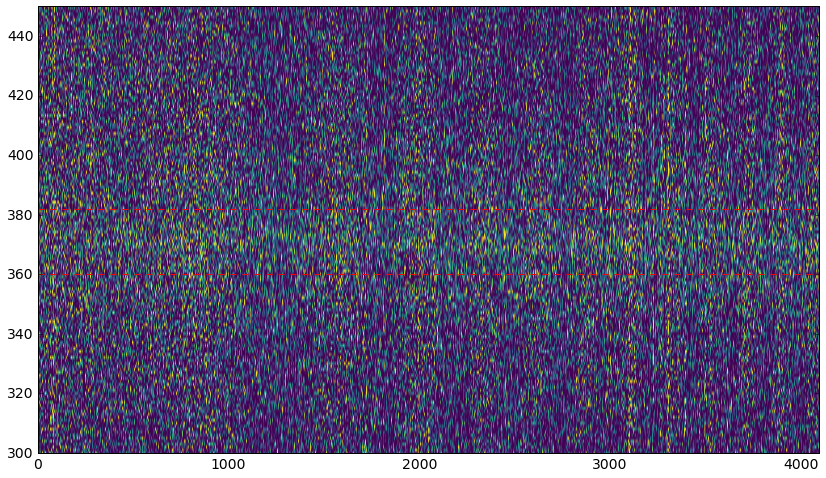

In [24]:
flux = d['FLUX'][0]
plt.imshow(flux,vmin=0,vmax=50,aspect='auto')
plt.ylim(300,450)

bounds = [360,382]
plt.axhline(bounds[0], c='r',ls='--')
plt.axhline(bounds[1], c='r',ls='--')

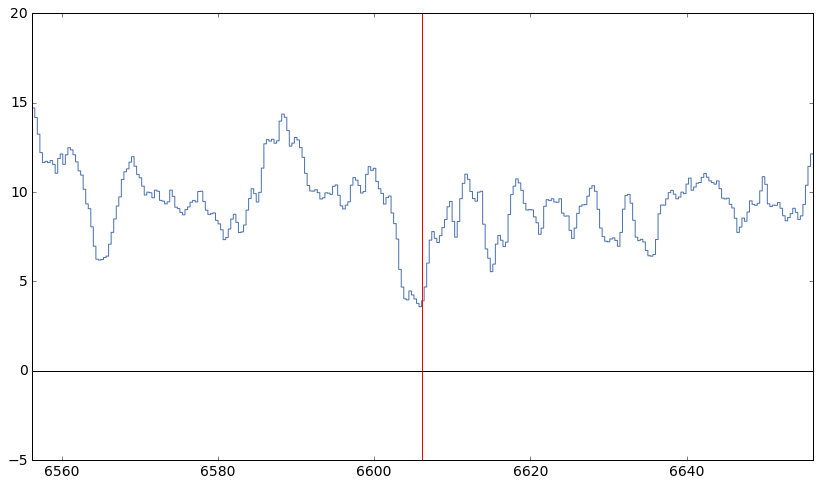

In [25]:
spec_flux = np.mean(flux[bounds[0]:bounds[1]],axis=0)

plt.step(d['LAMBDA0'][0], convolution.convolve(spec_flux, convolution.Box1DKernel(10)))
plt.xlim((1+zhost)*6563-50,(1+zhost)*6563+50)
plt.axvline((1+zhost)*6563, c='r')
plt.axhline(c='k')

More H-alpha-y?

## Try actually cross-correlating with the DEIMOS galaxy templates

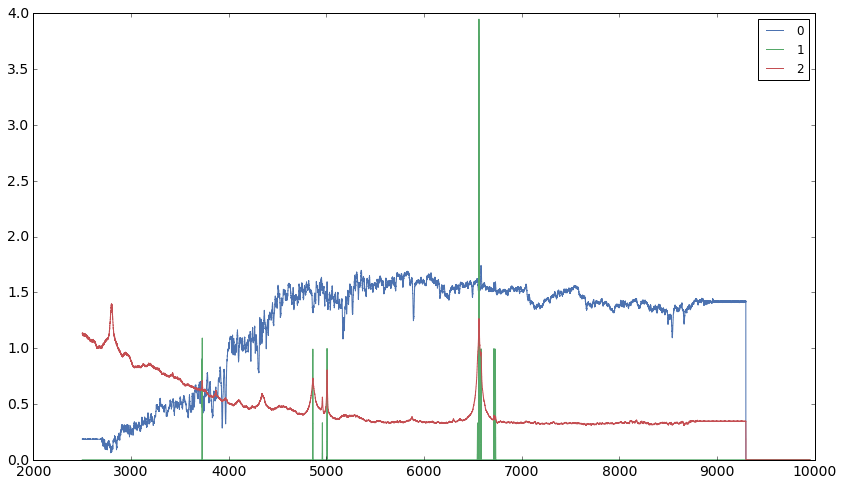

In [26]:
gal_templhdu = fits.open('deimos-galaxy.fits')[0]

templ_logwl = gal_templhdu.header['COEFF0'] + gal_templhdu.header['COEFF1']*np.arange(gal_templhdu.data.shape[-1])
templ_wl = 10**templ_logwl

for i, spec in enumerate(gal_templhdu.data):
    plt.step(templ_wl, spec, label=i)
plt.legend(loc=0)
None

In [27]:
redtempl = gal_templhdu.data[0]

In [28]:
_,xb, bspec, xr, rspec, bivar, rivar =erikutils.deimosutils.get_deimos_spec1d(goodfns[0])

interp_spec = np.zeros_like(templ_wl)
interp_spec += np.interp(templ_wl, xb, bspec,0, 0)
interp_spec += np.interp(templ_wl, xr, rspec,0, 0)

# this removes the 0s off the edges
msk = ~(((interp_spec==0)&(templ_wl<5000))|((interp_spec==0)&(templ_wl>6250)))

In [29]:
# compute the x-corr lag (in pixels) that corresponds to the host's redshift
pxlag_host = np.log10(zhost+1)/np.mean(np.diff(templ_logwl))
pxlag_host

142.41485183764399

<Quantity -75.23971031857852 km / s>

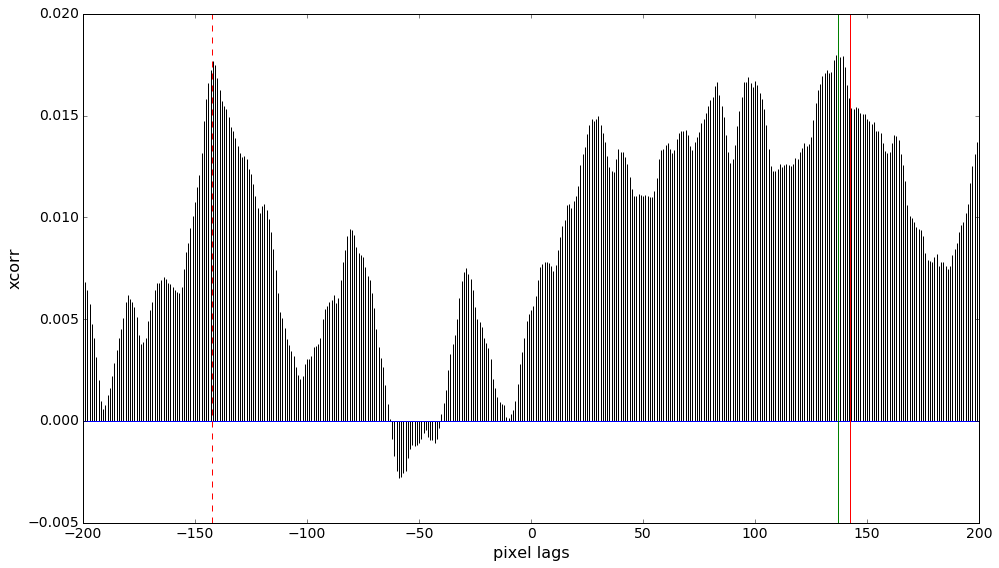

In [30]:
plt.xcorr(interp_spec[msk], redtempl[msk], maxlags=200, detrend=plt.mlab.detrend_mean)
plt.axvline(pxlag_host, c='r')
plt.axvline(-pxlag_host, c='r', ls='--')  # This is the wrong sign - i.e. it's a blueshift...
plt.xlabel('pixel lags')
plt.ylabel('xcorr')

guess_lag = 137
plt.axvline(guess_lag, c='g')
guess_z = 10**(guess_lag*np.mean(np.diff(templ_logwl)))-1

plt.tight_layout()
((guess_z-zhost)*cnst.c).to(u.km/u.s)

# DN1 

In [31]:
obj = 'DN1'

In [32]:
h = fits.getheader(spec1d_fns[obj][0], 1)
sccen = SkyCoord(h['RA'], h['DEC'], unit=(u.hour, u.deg))
url = get_cutout_url(sccen, 16*u.arcmin, scale=pxscale, opts='G')
sccen

<SkyCoord (ICRS): (ra, dec) in deg
    (221.86783333, -0.28175)>

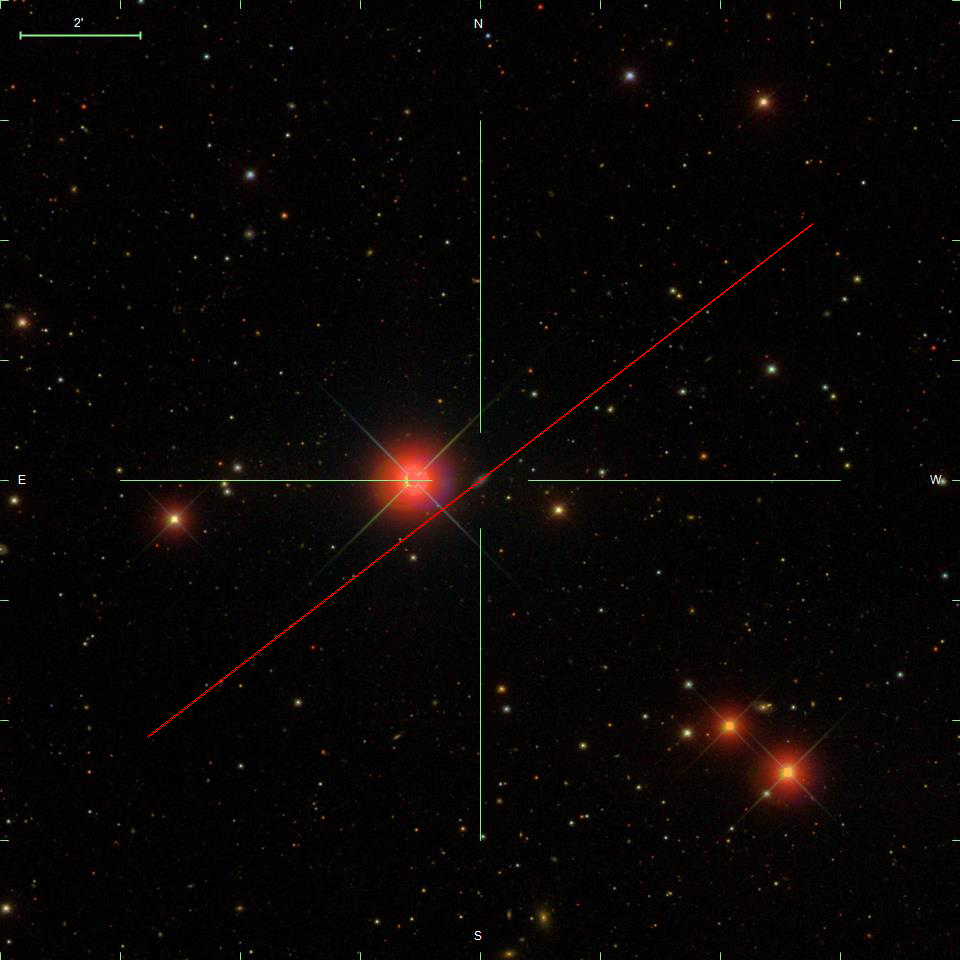

In [33]:
im = Image.open(urllib.request.urlopen(url))

# it's not actuall 90 deg from ROTATVAL to slit angle... but it's not totally wrong?  Maybe?
draw_box(im, im.width//2, im.height//2, 14*u.arcmin, 1*u.arcsec,  
         rot=h['ROTATVAL']*u.deg+90*u.deg, pxscale=pxscale)
pil_to_ipy_im(im)

In [34]:
show_all_slits(obj)b

SyntaxError: invalid syntax (<ipython-input-34-db067efefbf6>, line 1)

## 007

In [ ]:
goodfns = []
for fn in spec1d_fns[obj]:
    if '007' not in fn or 'serendip' in fn:
        continue
        
    plt.figure(figsize=(16,8))
    xb, bspec, xr, rspec = erikutils.deimosutils.plot_deimos_spec1d(fn, smoothing=-2, mady=50)
    goodfns.append(fn)
    plt.title(os.path.split(fn)[-1])

In [ ]:
_, xb, bspec, xr, rspec, _, _ = erikutils.deimosutils.get_deimos_spec1d(goodfns[0])

msk = (6900<xr)&(xr<7000)

model0 = (modeling.models.Gaussian1D(amplitude=2000,mean=6918, stddev=1.) +
          modeling.models.Gaussian1D(amplitude=12000,mean=6930, stddev=1.) + 
          modeling.models.Gaussian1D(amplitude=3000,mean=6955, stddev=.5) + 
          modeling.models.Const1D(amplitude=1000))

model = modeling.fitting.LevMarLSQFitter()(model0, xr[msk], rspec[msk])

plt.figure(figsize=(16, 6))
plt.step(xr[msk], rspec[msk])
plt.plot(xr[msk], model0(xr[msk]))
plt.plot(xr[msk], model(xr[msk]))
plt.ylim(0,15000)
model

In [ ]:
model.mean_0/6548.-1, model.mean_1/6563-1, model.mean_2/6585-1

Clearly redshift .056, not satellite

# MD2 

In [ ]:
obj='MD2'

In [ ]:
h = fits.getheader(spec1d_fns[obj][0], 1)
sccen = SkyCoord(h['RA'], h['DEC'], unit=(u.hour, u.deg))
url = get_cutout_url(sccen, 16*u.arcmin, scale=pxscale, opts='G')
sccen

In [ ]:
im = Image.open(urllib.request.urlopen(url))

# it's not actuall 90 deg from ROTATVAL to slit angle... but it's not totally wrong?  Maybe?
draw_box(im, im.width//2, im.height//2, 14*u.arcmin, 1*u.arcsec,  
         rot=h['ROTATVAL']*u.deg+90*u.deg, pxscale=pxscale)
pil_to_ipy_im(im)

Target seems to be off... is it the thing to the W of the supposed target?

In [ ]:
show_all_slits(obj)

## 007 

In [ ]:
goodfns = []
for fn in spec1d_fns[obj]:
    if '007' not in fn or 'serendip' in fn:
        continue
        
    plt.figure(figsize=(16,8))
    xb, bspec, xr, rspec = erikutils.deimosutils.plot_deimos_spec1d(fn, smoothing=-2, mady=50)
    goodfns.append(fn)
    plt.title(os.path.split(fn)[-1])

In [ ]:
_, xb, bspec, xr, rspec, _, _ = erikutils.deimosutils.get_deimos_spec1d(goodfns[0])

msk = (7050<xr)&(xr<7150)

model0 = (modeling.models.Gaussian1D(amplitude=3000,mean=7088, stddev=1.) + 
          modeling.models.Gaussian1D(amplitude=1000,mean=7111.5, stddev=.5) + 
          modeling.models.Const1D(amplitude=100))

model = modeling.fitting.LevMarLSQFitter()(model0, xr[msk], rspec[msk])

plt.figure(figsize=(16, 6))
plt.step(xr[msk], rspec[msk])
plt.plot(xr[msk], model0(xr[msk]))
plt.plot(xr[msk], model(xr[msk]))
plt.ylim(0,5000)
model

In [ ]:
model.mean_0/6563-1, model.mean_1/6585.-1

In [ ]:
erikutils.deimosutils.plot_deimos_spec1d(goodfns[0], smoothing=-2, mady=50)
for line in [4861, 4959, 5007, 6563]:
    plt.axvline(line*1.08, color='k', ls=':')
plt.xlim(4959,5500)
plt.ylim(0,3000)

Redshift 1.08 - definitely not a satellite